In [1]:
import oommfc
oommfc.runner.runner = oommfc.oommf.TclOOMMFRunner("/home/endereger/.conda/envs/ubermag_env/opt/oommf/oommf.tcl")


/home/jovyan/.cache/matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /localscratch/3035080/matplotlib-_9r2f52_ because there was an issue with the default path (/home/jovyan/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Running OOMMF (TclOOMMFRunner)[2025/04/18 10:19]... (1.3 s)
OOMMF found and running.


In [2]:
oommfc.runner

OOMMF runner: TclOOMMFRunner(/home/endereger/.conda/envs/ubermag_env/opt/oommf/oommf.tcl)
runner is cached: True

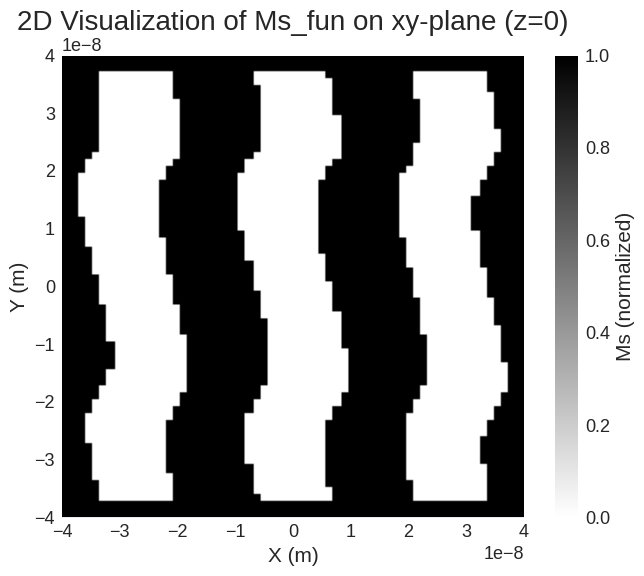

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import oommfc as mc
import discretisedfield as df
import micromagneticmodel as mm

region = df.Region(p1=(-50e-9, -50e-9, -50e-9), p2=(50e-9, 50e-9, 50e-9))
mesh = df.Mesh(region=region, cell=(2.5e-9, 2.5e-9, 2.5e-9))

system = mm.System(name="hysteresis")
system.energy = (
    mm.Exchange(A=1e-12)
    + mm.UniaxialAnisotropy(K=4e5, u=(0, 0, 1))
    + mm.DMI(D=1e-3, crystalclass="T")
    #+ mm.MagnetoStrictiveSelf(C1=1,C2=1,C12=1,e_1=1,e_2=1,e_12=1),
    + mm.MagnetoElastic(B1=1e7, B2=1e7, e_diag=(1, 1, 1),
                        e_offdiag=(0, 0, 0))
)

image_path = "spinodoid_image.png"
image = Image.open(image_path).convert("L")  
image = image.resize((64, 64))  
image_data = np.array(image) 

x_min, x_max = -40e-9, 40e-9
y_min, y_max = -40e-9, 40e-9
z_min, z_max = -1.25e-9, 1.25e-9  
frame_thickness = 2.5e-9

def Ms_fun(point):
    x, y, z = point

    if x_min <= x <= x_max and y_min <= y <= y_max and z_min <= z <= z_max:
        if (
            x <= x_min + frame_thickness or x >= x_max - frame_thickness or
            y <= y_min + frame_thickness or y >= y_max - frame_thickness
        ):
            return 1e6  

        ix = int(((x - x_min) / (x_max - x_min)) * (image_data.shape[1] - 1))
        iy = int(((y - y_min) / (y_max - y_min)) * (image_data.shape[0] - 1))

        intensity = image_data[iy, ix]

        if intensity < 0.1:  
            return 0
        
        return intensity * 1e6  

    return 0  

num_points = 200  

x_vals = np.linspace(x_min, x_max, num_points)
y_vals = np.linspace(y_min, y_max, num_points)
X, Y = np.meshgrid(x_vals, y_vals)

Ms_values = np.zeros_like(X)

for i in range(num_points):
    for j in range(num_points):
        Ms_values[i, j] = Ms_fun((X[i, j], Y[i, j], 0))

Ms_values[Ms_values > 0] = 1 
plt.figure(figsize=(8, 6))
plt.imshow(Ms_values, extent=[x_min, x_max, y_min, y_max], origin="lower", cmap="gray_r")
plt.colorbar(label="Ms (normalized)")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("2D Visualization of Ms_fun on xy-plane (z=0)")
plt.show()
system.m = df.Field(mesh, nvdim=3, value=(0, 0, -1), norm=Ms_fun, valid="norm")


In [4]:
system.energy 

Exchange(A=1e-12) + UniaxialAnisotropy(K=400000.0, u=(0, 0, 1)) + DMI(D=0.001, crystalclass='T') + MagnetoElastic(B1=10000000.0, B2=10000000.0, e_diag=(1, 1, 1), e_offdiag=(0, 0, 0))

In [5]:
Hmin = (0, 0, -1 / mm.consts.mu0)
Hmax = (0, 0, 1 / mm.consts.mu0)

In [6]:
n = 21

In [7]:
hd = mc.HysteresisDriver()
hd.drive(system, Hmin=Hmin, Hmax=Hmax, n=n)

Running OOMMF (TclOOMMFRunner)[2025/04/18 10:19]... (72.4 s)


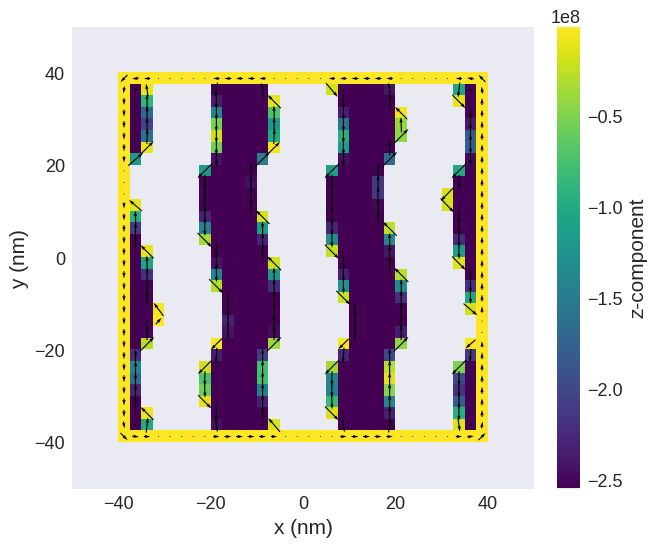

In [8]:
system.m.sel(z=-1.25e-9).mpl()

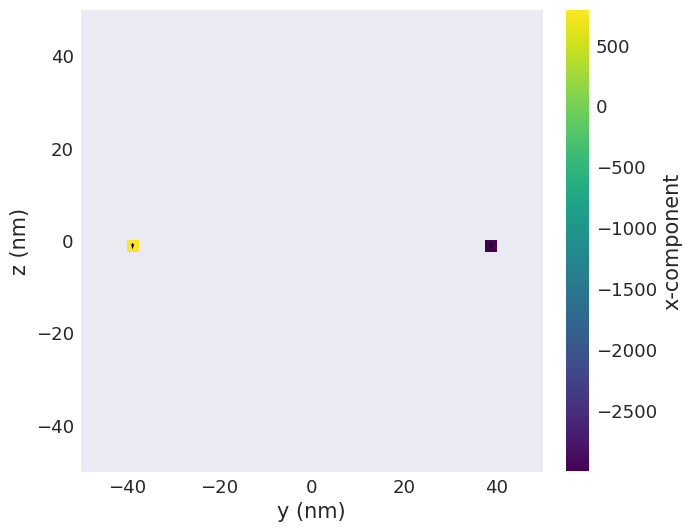

In [9]:
system.m.sel("x").mpl()

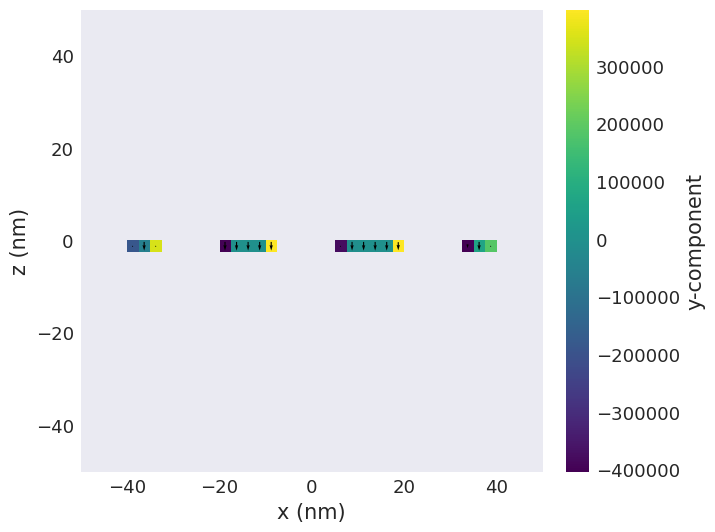

In [10]:
system.m.sel("y").mpl()

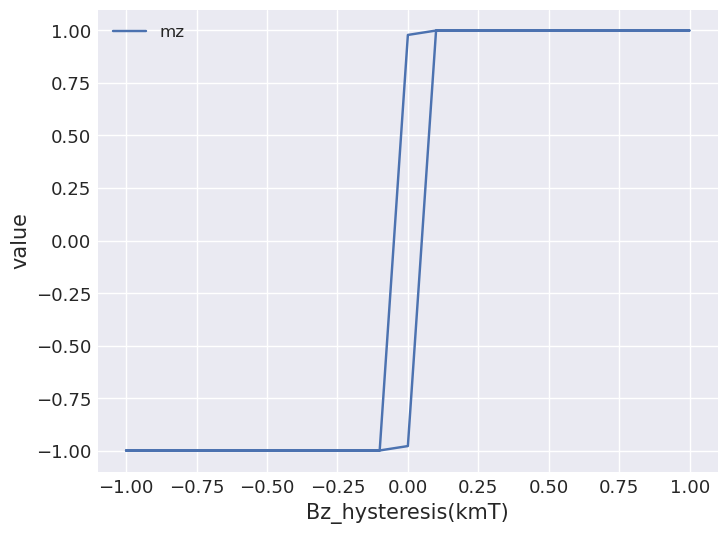

In [11]:
system.table.mpl(x="Bz_hysteresis", y=["mz"])
